In [12]:
import torch
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

import os

from main import *

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
SAMPLE = 1
sample_path = f'data/{SAMPLE}/'
im_path = sample_path + "image.jpg"

(689, 1024, 3)

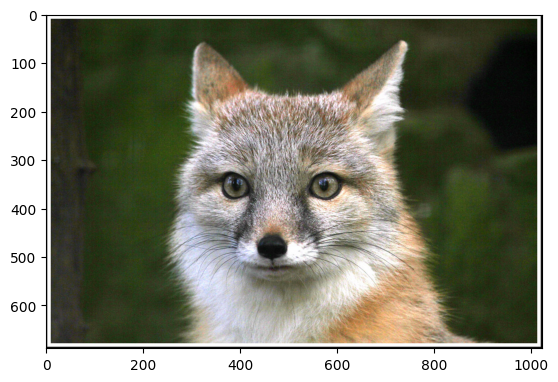

In [14]:
im = io.imread(im_path)
display(im.shape)
plt.imshow(im)

In [15]:
batch_size = 10_000
dt = CoordinateDataset(image_path=im_path)
dl = DataLoader(dt, batch_size=batch_size, shuffle=True)
len(dl)

71

In [16]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [17]:
model = Net(device=device, L=15)
print(model)

Net(
  (pe): PositionalEncoding()
  (mlp): Sequential(
    (0): Linear(in_features=42, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=256, bias=True)
    (5): ReLU()
    (6): Linear(in_features=256, out_features=3, bias=True)
    (7): Sigmoid()
  )
)


In [18]:
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)

In [19]:
loss_list = []
PSNR_list = []

def train(model, dl, loss_fn, optimizer):
    for batch, data in enumerate(dl):
        coords, color_gt = data
        optimizer.zero_grad()
        color_model = model(coords.to(device))
        loss = loss_fn(color_model, color_gt.to(device))
        loss_list.append(loss.item())
        PSNR_list.append(PSNR(loss).item())
        loss.backward()
        optimizer.step()
        if batch % 10 == 0:
            print(f'Batch {batch}, Loss: {loss.item()}, PSNR: {PSNR(loss).item()}')

In [ ]:
RUN = 2

In [9]:
epochs = 40
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(model, dl, loss_fn, optimizer)
    if t % 8 == 0:
        pred_im = inference(model, *im.shape[:2])
        io.imsave(sample_path + f"run2/output_epoch_{t}.jpg", pred_im)
print("Done!")

Epoch 1
-------------------------------
Batch 0, Loss: 0.10388574004173279, PSNR: 9.834441184997559
Batch 10, Loss: 0.06638500839471817, PSNR: 11.77929973602295
Batch 20, Loss: 0.048492636531591415, PSNR: 13.143242835998535
Batch 30, Loss: 0.031336065381765366, PSNR: 15.039554595947266
Batch 40, Loss: 0.023816609755158424, PSNR: 16.231201171875
Batch 50, Loss: 0.0169731043279171, PSNR: 17.7023868560791
Batch 60, Loss: 0.012493520975112915, PSNR: 19.033151626586914
Batch 70, Loss: 0.00939320120960474, PSNR: 20.27186393737793
Epoch 2
-------------------------------
Batch 0, Loss: 0.00926431268453598, PSNR: 20.33186912536621
Batch 10, Loss: 0.007847810164093971, PSNR: 21.052515029907227
Batch 20, Loss: 0.007038621231913567, PSNR: 21.52512550354004
Batch 30, Loss: 0.006147470325231552, PSNR: 22.113035202026367
Batch 40, Loss: 0.005847666412591934, PSNR: 22.33017349243164
Batch 50, Loss: 0.005330683663487434, PSNR: 22.7321720123291
Batch 60, Loss: 0.0048567913472652435, PSNR: 23.13650512695

Text(0.5, 1.0, 'PSNR')

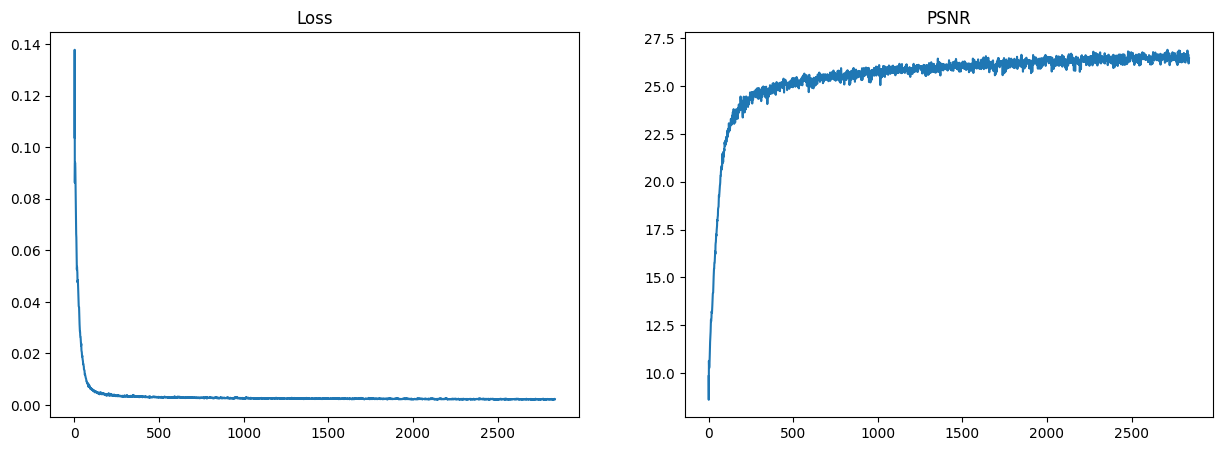

In [10]:
ax, fig = plt.subplots(1, 2, figsize=(15, 5))
fig[0].plot(loss_list)
fig[0].set_title('Loss')

fig[1].plot(PSNR_list)
fig[1].set_title('PSNR')